## Dataset Au-Au: ponta de ouro e substrato de ouro
### Teste 5 - 2x2, séries temporais cortadas em t=450, `grid_four`, 100 séries temporais.
### Importando bibliotecas e dados

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [10]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [11]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [12]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [13]:
force_data = D3011_data['vDeflection_N']

In [14]:
force_data.shape

(1024, 800)

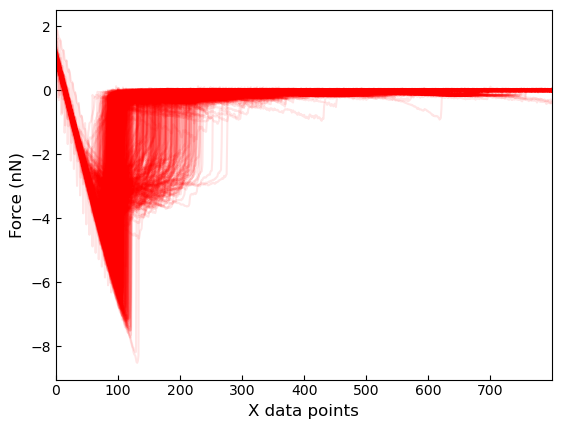

In [15]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **primeiras 100 curvas** do *dataset*.

In [16]:
train_set = force_data[:100]
test_set = force_data[100:]

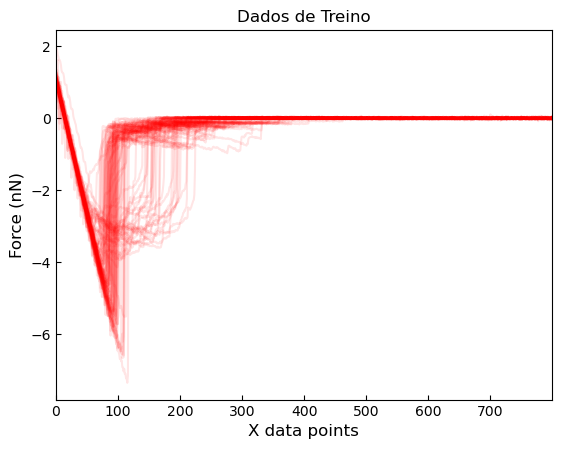

In [17]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [18]:
len(train_set[0])

800

In [19]:
train_set_cort = np.zeros((100,450))

for i in range(len(train_set_cort)):
    train_set_cort[i] = train_set[i][:450]

train_set_cort

array([[ 1.97609330e+00,  1.93161600e+00,  1.88872630e+00, ...,
        -1.80709350e-02, -1.40128464e-02, -2.81323730e-02],
       [ 1.23851870e+00,  1.14368230e+00,  1.05082560e+00, ...,
        -9.88373450e-03, -3.16980570e-02, -2.16886210e-02],
       [ 9.95194600e-01,  8.99093900e-01,  8.43862650e-01, ...,
        -3.44414800e-02, -1.97907850e-02, -2.45819940e-02],
       ...,
       [ 1.03345590e+00,  1.12258920e+00,  9.60693400e-01, ...,
         1.19244760e-02, -4.57916900e-03, -1.92376020e-03],
       [ 9.94958600e-01,  9.60087000e-01,  9.53442800e-01, ...,
         1.27551770e-02, -9.92502100e-03, -1.07562280e-02],
       [ 1.19850620e+00,  1.08416450e+00,  1.00300300e+00, ...,
         5.04076770e-03,  2.56601420e-02,  9.82679100e-04]])

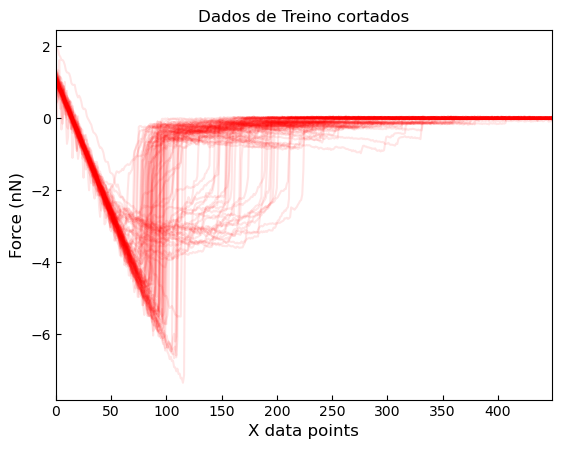

In [20]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set_cort:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,train_set_cort.shape[1]-1])

ax.set_title("Dados de Treino cortados")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [21]:
size = len(train_set_cort[0])
sample_size = len(train_set_cort)
print(size, sample_size)

450 100


In [24]:
joined_data = train_set_cort[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set_cort[i]))
len(joined_data)

45000

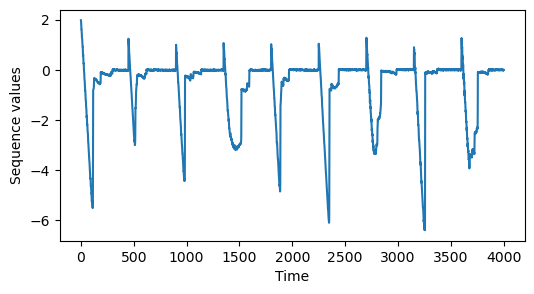

In [25]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [26]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 15 s, sys: 0 ns, total: 15 s
Wall time: 15 s


In [27]:
print(mp[1])

[13487. 13488. 13489. ... 29247. 29248. 29249.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

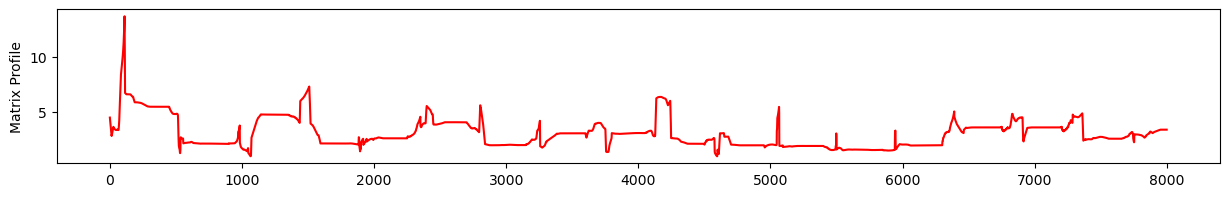

In [28]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [29]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 107 ms, sys: 30.4 ms, total: 138 ms
Wall time: 147 ms


41

Criando uma lista com os centros de motifs.

In [30]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

45000

In [31]:
len(motif_center_list)

41

### Treinando a rede DTW-SOM

In [32]:
%time
rows = 2
cols = 2
structure = type_conn.grid_four
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


In [33]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 6.8185
Epoch 2 achieved an average quantization error of 6.473
Epoch 3 achieved an average quantization error of 6.2922
Epoch 4 achieved an average quantization error of 6.2709
Epoch 5 achieved an average quantization error of 6.286
Epoch 6 achieved an average quantization error of 6.3043
Epoch 7 achieved an average quantization error of 6.3204
Epoch 8 achieved an average quantization error of 6.3058
Epoch 9 achieved an average quantization error of 6.297
Epoch 10 achieved an average quantization error of 6.2885
Epoch 11 achieved an average quantization error of 6.2725
Epoch 12 achieved an average quantization error of 6.2629
Epoch 13 achieved an average quantization error of 6.2612
Epoch 14 achieved an average quantization error of 6.2596
Epoch 15 achieved an average quantization error of 6.2665
Epoch 16 achieved an average quantization error of 6.2702
Epoch 17 achieved an average quantization error of 6.2804
Epoch 18 achieved an avera

50

### Resultados

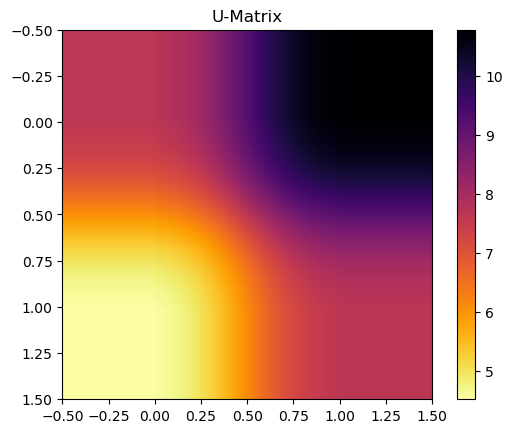

In [34]:
network.show_distance_matrix()

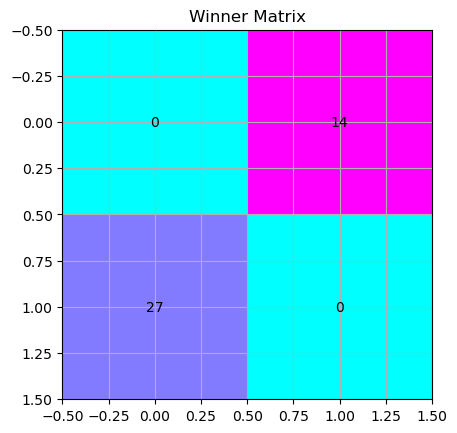

In [35]:
network.show_winner_matrix()

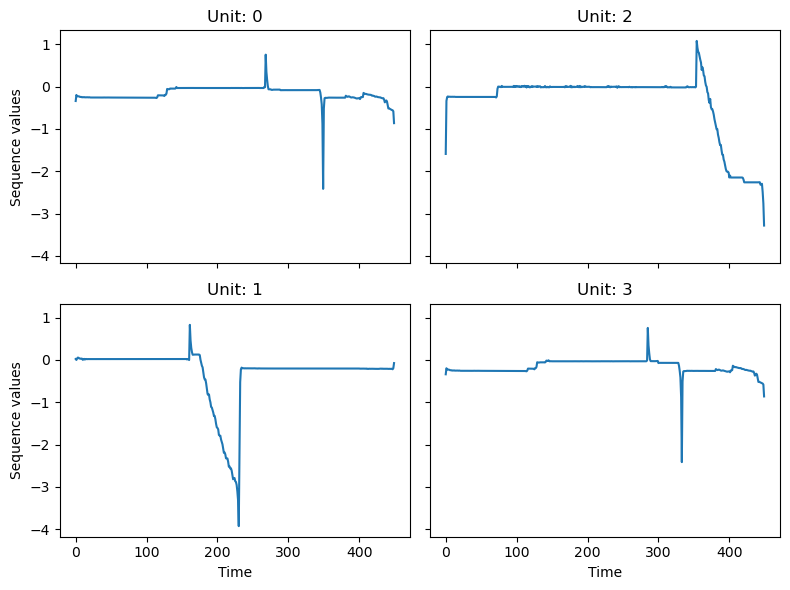

In [36]:
n_neurons = network._size
fig, axs = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

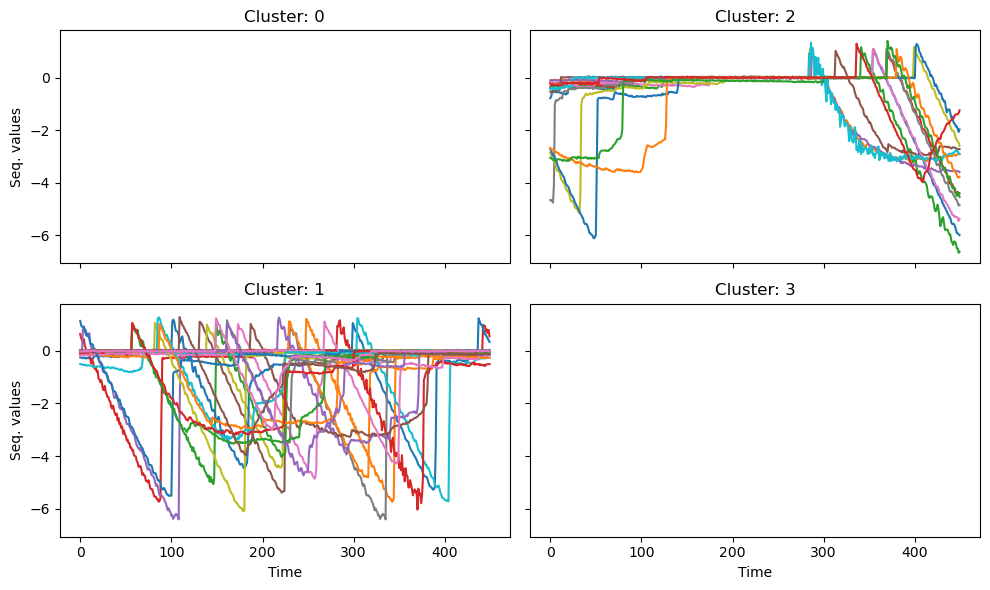

In [37]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

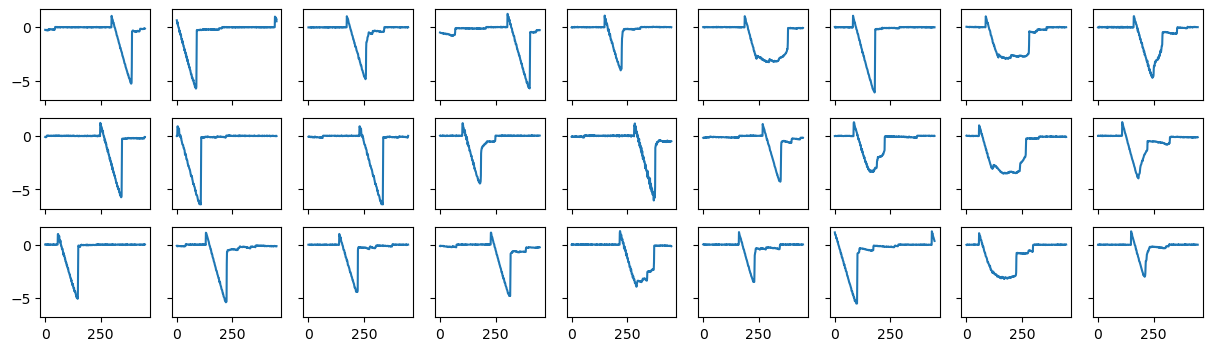

In [45]:
fig, axs = plt.subplots(3, 9, figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[1]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/3)
    row = i % 3
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

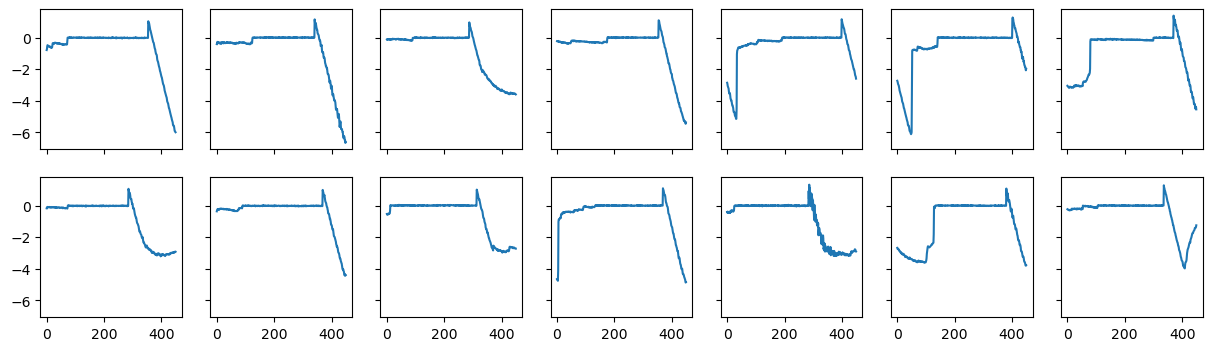

In [46]:
fig, axs = plt.subplots(2, 7,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()